### create figure for hierarchy example
1. get latent distances vs sequential distances
2. get MI of markov model
3. get MI of recursively generated sequence - store the average latent distance for each of the sequential distances
4. Plot latent distance by MI
5. plot sequential distance by MI

In [73]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

#### Make an example tree

In [94]:
r = 3 # branching factor
h = 3 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h

In [95]:
list(btree.nodes)[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [96]:
list(btree.edges)[:10]

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 10)]

In [97]:
nx.shortest_path(btree, 0, 27)

[0, 2, 8, 27]

In [100]:
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
#pos[0] = (pos[0][0], pos[0][1]-32)

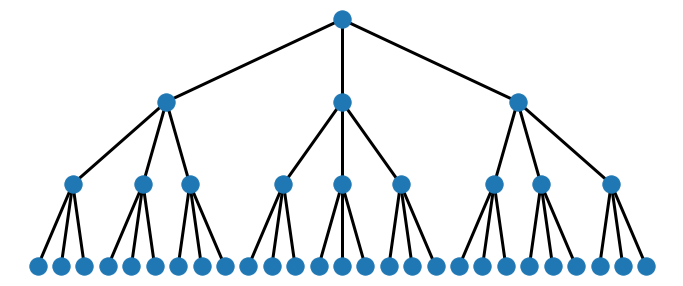

In [102]:
fig, ax = plt.subplots(figsize=(12,5))
nx.draw(btree,pos,with_labels=False,arrows=False, width = 3, ax=ax)

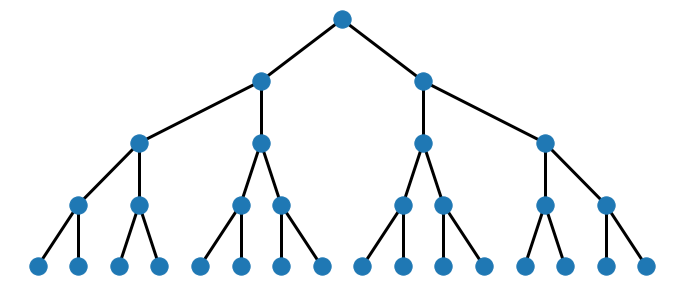

In [119]:
r = 2 # branching factor
h = 4 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h
pos=nx.drawing.nx_agraph.graphviz_layout(btree,prog='dot')
fig, ax = plt.subplots(figsize=(12,5))
nx.draw(btree,pos,with_labels=False,arrows=False, width = 3, ax=ax)

#### get distances between nodes

In [7]:
import pandas as pd
from tqdm.autonotebook import tqdm
from joblib import parallel_backend
from joblib import Parallel, delayed

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
loc_df = pd.DataFrame(pos).T
loc_df.columns = ['x', 'y']
loc_df[:3]

,x,y
0,567.0,306.0
1,423.0,234.0
2,711.0,234.0


In [51]:
r = 2 # branching factor
h = 10 # height
btree = nx.balanced_tree(r=r,h=h)
n_final_nodes = r**h

In [52]:
len(btree.nodes)

2047

In [53]:
lowest_level_nodes = list(list(btree.nodes)[-n_final_nodes:])
lowest_level_nodes
len(lowest_level_nodes)

1024

In [54]:
l = [
    [(node1, node2, n1 - n2) for n2, node2 in enumerate(lowest_level_nodes) if n2 < n1]
    for n1, node1 in enumerate(lowest_level_nodes)
]
pair_list = [item for sublist in l for item in sublist]
latent_vs_sequential_dist = pd.DataFrame(
    pair_list, columns=["node1", "node2", "sequential_distance"]
)
len(pair_list)

523776

In [60]:
with Parallel(n_jobs=1, prefer="threads") as parallel:
    latent_distances = [
        parallel(delayed(nx.shortest_path_length)(btree, row.node1, row.node2)
        for idx, row in tqdm(
            latent_vs_sequential_dist.iterrows(), total=len(latent_vs_sequential_dist)
        )
                )
    ]
latent_vs_sequential_dist['latent_distances'] = latent_distances[0]

In [61]:
row = latent_vs_sequential_dist.iloc[0]

In [62]:
nx.shortest_path_length(btree, row.node1, row.node2)

2

In [63]:
latent_vs_sequential_dist[:3]

,node1,node2,sequential_distance,latent_distances
0,1024,1023,1,2
1,1025,1023,2,4
2,1025,1024,1,4


In [64]:
# summarize distances
dist_summary = latent_vs_sequential_dist.groupby(['sequential_distance']).agg(['mean', 'std'])
dist_summary[:3]

node1               node2             latent_distances  \
                       mean         std    mean         std             mean   
sequential_distance                                                            
1                    1535.0  295.458965  1534.0  295.458965         3.980450   
2                    1535.5  295.170290  1533.5  295.170290         5.964775   
3                    1536.0  294.881615  1533.0  294.881615         6.950049   

                               
                          std  
sequential_distance            
1                    2.759720  
2                    2.715128  
3                    2.856443

In [ ]:
# fit logarithmic growth model

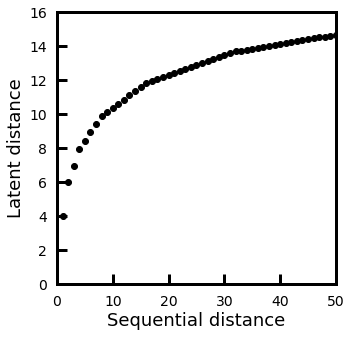

In [128]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], color = 'k')
ax.set_xlim([0, 50])
ax.set_ylim([0, 16])
ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Latent distance', fontsize=18)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)



In [305]:
import lmfit

def residuals(y_true, y_model, x, logscaled=False):
    if logscaled:
        return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
    else:
        return np.abs(y_true - y_model)

def model_res(p, x, y, fit, model):
    if fit == "lin":
        return residuals(y, model(p, x), x)
    else:
        return residuals(y, model(p, x), x, logscaled=True)
    
# fitting model
def fit_model_iter(model, n_iter=10, **kwargs):
    """ re-fit model n_iter times and choose the best fit
    chooses method based upon best-fit
    """
    models = []
    AICs = []
    for iter in np.arange(n_iter):
        results_model = model.minimize(**kwargs)
        models.append(results_model)
        AICs.append(results_model.aic)
    return models[np.argmin(AICs)]

def get_y(model, results, x):
    return model({i: results.params[i].value for i in results.params}, x)

def exp_decay(p, x):
    return p["e_init"] * np.exp(-x * p["e_decay_const"]) + p["intercept"]

def log_growth(p, x):
    return p['a'] * np.log(p['b'] * x) + p['intercept']



# decay types
def powerlaw_decay(p, x):
    return p["p_init"] * x ** (p["p_decay_const"]) + p["intercept"]

p_log_growth = lmfit.Parameters()
p_log_growth.add_many(
    ("a", 2.5, True),
    ("b", 1, True),
    ("intercept", 1.0, True),
)

#### Fit log growth

In [306]:
fit='linear'
n_iter=1
method=["nelder", "leastsq", "least-squares"]

In [307]:
d = dist_summary.index.values[:50]
sig = dist_summary.latent_distances['mean'][:50]

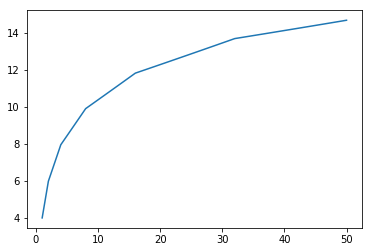

In [308]:
plt.plot(d, sig)

In [314]:
results_lg_min = lmfit.Minimizer(
    model_res, p_log_growth, fcn_args=(d, sig, fit, log_growth), nan_policy="omit"
)
results_lg = fit_model_iter(results_lg_min, n_iter=n_iter, **{"method": 'nelder'})
#y_lg = log_growth(p={'a':5,'b':0.5, 'intercept':1.0}, x=d)
d = np.arange(51)
y_lg = get_y(log_growth, results_lg, d)
print(results_lg.params)

Parameters([('a', <Parameter 'a', 2.7698218212547148, bounds=[-inf:inf]>), ('b', <Parameter 'b', 2.2503003322456503, bounds=[-inf:inf]>), ('intercept', <Parameter 'intercept', 1.7418769260381528, bounds=[-inf:inf]>)])


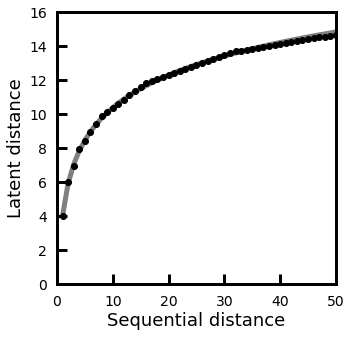

In [315]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], color = 'k')
ax.plot(d, y_lg, alpha = 0.5, color= 'k', lw=5)

ax.set_xlim([0, 50])
ax.set_ylim([0, 16])
ax.set_xlabel('Sequential distance', fontsize=18)
ax.set_ylabel('Latent distance', fontsize=18)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.grid(False)
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)

In [311]:
### look at latent growth

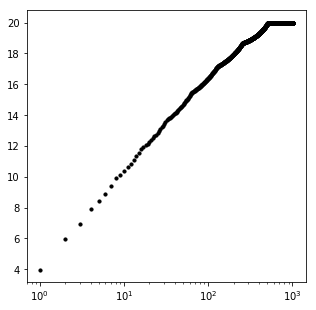

In [194]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(dist_summary.index.values, dist_summary.latent_distances['mean'], s=10, color = 'k')
ax.set_xscale('log')
#ax.set_xlim([1,50])
#ax.set_ylim([0, 16])

In [121]:
dist_summary.to_pickle('latent_vs_sequential_distance.pickle')

In [124]:
dist_summary

node1               node2             latent_distances  \
                       mean         std    mean         std             mean   
sequential_distance                                                            
1                    1535.0  295.458965  1534.0  295.458965         3.980450   
2                    1535.5  295.170290  1533.5  295.170290         5.964775   
3                    1536.0  294.881615  1533.0  294.881615         6.950049   
4                    1536.5  294.592939  1532.5  294.592939         7.937255   
5                    1537.0  294.304264  1532.0  294.304264         8.423945   
6                    1537.5  294.015589  1531.5  294.015589         8.911591   
7                    1538.0  293.726914  1531.0  293.726914         9.400197   
8                    1538.5  293.438239  1530.5  293.438239         9.889764   
9                    1539.0  293.149564  1530.0  293.149564        10.128079   
10                   1539.5  292.860888  1529.5  292.860888        10.366864   
11                   1540.0  292.572213  1529.0  292.572213        10.606120   
12                   1540.5  292.283538  1528.5  292.283538        10.845850   
13                   1541.0  291.994863  1528.0  291.994863        11.086053   
14                   1541.5  291.706188  1527.5  291.706188        11.326733   
15                   1542.0  291.417513  1527.0  291.417513        11.567889   
16                   1542.5  291.128837  1526.5  291.128837        11.809524   
17                   1543.0  290.840162  1526.0  290.840162        11.924528   
18                   1543.5  290.551487  1525.5  290.551487        12.039761   
19                   1544.0  290.262812  1525.0  290.262812        12.155224   
20                   1544.5  289.974137  1524.5  289.974137        12.270916   
21                   1545.0  289.685462  1524.0  289.685462        12.386839   
22                   1545.5  289.396786  1523.5  289.396786        12.502994   
23                   1546.0  289.108111  1523.0  289.108111        12.619381   
24                   1546.5  288.819436  1522.5  288.819436        12.736000   
25                   1547.0  288.530761  1522.0  288.530761        12.852853   
26                   1547.5  288.242086  1521.5  288.242086        12.969940   
27                   1548.0  287.953411  1521.0  287.953411        13.087262   
28                   1548.5  287.664735  1520.5  287.664735        13.204819   
29                   1549.0  287.376060  1520.0  287.376060        13.322613   
30                   1549.5  287.087385  1519.5  287.087385        13.440644   
...                     ...         ...     ...         ...              ...   
994                  2031.5    8.803408  1037.5    8.803408        20.000000   
995                  2032.0    8.514693  1037.0    8.514693        20.000000   
996                  2032.5    8.225975  1036.5    8.225975        20.000000   
997                  2033.0    7.937254  1036.0    7.937254        20.000000   
998                  2033.5    7.648529  1035.5    7.648529        20.000000   
999                  2034.0    7.359801  1035.0    7.359801        20.000000   
1000                 2034.5    7.071068  1034.5    7.071068        20.000000   
1001                 2035.0    6.782330  1034.0    6.782330        20.000000   
1002                 2035.5    6.493587  1033.5    6.493587        20.000000   
1003                 2036.0    6.204837  1033.0    6.204837        20.000000   
1004                 2036.5    5.916080  1032.5    5.916080        20.000000   
1005                 2037.0    5.627314  1032.0    5.627314        20.000000   
1006                 2037.5    5.338539  1031.5    5.338539        20.000000   
1007                 2038.0    5.049752  1031.0    5.049752        20.000000   
1008                 2038.5    4.760952  1030.5    4.760952        20.000000   
1009                 2039.0    4.472136  1030.0    4.472136        20.000000   
1010                 2